## SLR in Sigmoid Fit

Krushke's 16_SimpleLinearRegressionPyMC.py
Estimating the mean and standard deviation of a Gaussian likelihood with a
hierarchical model.

In [124]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import theano.tensor as T
import sys
from io import StringIO

from scipy.stats import norm, multivariate_normal, beta, binom, stats
from scipy.stats import t as stats_t
from scipy.special import beta as beta_func
from scipy.special import binom as special_binom
from scipy.special import betaln as special_betaln
from scipy.optimize import fmin
from scipy.interpolate import spline
from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [125]:
"""
This code was taken form the PyMC library https://github.com/pymc-devs/pymc
"""

import numpy as np

def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)

    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = np.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = np.shape(tx)
        # Container list for intervals
        intervals = np.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = np.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return np.array(intervals)
    else:
        # Sort univariate node
        sx = np.sort(x)
        return np.array(calc_min_interval(sx, alpha))
    
def plot_post(param_sample_vec, cred_mass=0.95, comp_val=False,
              ROPE=False, ylab='', xlab='parameter', fontsize=14, labelsize=14,
              title='', framealpha=1, facecolor='skyblue', edgecolor='white',
              show_mode=True, bins=50):
    
    #compute HDI
    HDI = hpd(param_sample_vec, 1-cred_mass)

    post_summary = {'mean':0,'median':0,'mode':0, 'hdi_mass':0,'hdi_low':0,
                   'hdi_high':0, 'comp_val':0, 'pc_gt_comp_val':0, 'ROPE_low':0,
                   'ROPE_high':0, 'pc_in_ROPE':0}
    post_summary['mean'] = np.mean(param_sample_vec)
    post_summary['median'] = np.median(param_sample_vec)
    post_summary['mode'] = stats.mode(param_sample_vec)[0]
    post_summary['hdi_mass'] = cred_mass
    post_summary['hdi_low'] = HDI[0]
    post_summary['hdi_high'] = HDI[1]

    # Plot histogram.
    n, bins, patches = plt.hist(param_sample_vec, normed=True, bins=bins,
                                edgecolor=edgecolor, facecolor=facecolor)
    plt.xlabel(xlab, fontsize=fontsize)
    plt.ylabel(ylab, fontsize=fontsize)
    plt.title(title, fontsize=fontsize)

    cv_ht = 0.75*np.max(n)
    cen_tend_ht = 0.9 * cv_ht
    ROPE_text_ht = 0.55 * cv_ht
#    # Display mean or mode:
    if show_mode:
        plt.plot(0, label='mode = %.2f' % post_summary['mode'], alpha=0)
    else:
        plt.plot(0, label='mean = %.2f' % post_summary['mean'], alpha=0)
    # Display the comparison value.

    if comp_val is not False:
        pc_gt_comp_val = 100 * np.sum(param_sample_vec > comp_val)/len(param_sample_vec)
        pc_lt_comp_val = 100 - pc_gt_comp_val
        plt.plot([comp_val, comp_val], [0, cv_ht], color='darkgreen',
                 linestyle='--', linewidth=2,
                 label='%.1f%% <%.1f < %.1f%%'
                 % (pc_lt_comp_val, comp_val, pc_gt_comp_val))
        post_summary['comp_val'] = comp_val
        post_summary['pc_gt_comp_val'] = pc_gt_comp_val
#    # Display the ROPE.
    if ROPE is not False:
        rope_col = 'darkred'
        pc_in_ROPE = round(np.sum((param_sample_vec > ROPE[0]) & (param_sample_vec < ROPE[1]))/len(param_sample_vec)*100)
        plt.plot([ROPE[0], ROPE[0]], [0, 0.96*ROPE_text_ht], color=rope_col,
                linestyle=':', linewidth=4,
                label='%.1f%% in ROPE' % pc_in_ROPE)
        plt.plot([ROPE[1], ROPE[1]], [0, 0.96*ROPE_text_ht], color=rope_col,
                linestyle=':', linewidth=4)
        post_summary['ROPE_low'] = ROPE[0] 
        post_summary['ROPE_high'] = ROPE[1] 
        post_summary['pc_in_ROPE'] = pc_in_ROPE
#    # Display the HDI.
    plt.plot(HDI, [0, 0], linewidth=6, color='k', label='HDI %.1f%% %.3f-%.3f' % (cred_mass*100, HDI[0], HDI[1]))
    plt.legend(loc='upper left', fontsize=labelsize, framealpha=framealpha)
    return post_summary


Logistic function (Sigmoid) $S(x)$ is defined as 
$$ S(x)=a+\frac{b}{1+e^{-c(x-d)}},$$ where $a$  is the function minimum, $b$  is the difference between the maximum and the minimum, $c$ is the steepness, and $d$ is the x - value of the sigmoid's midpoint.

In [126]:
def sigmoid(a, b, c, d, x):    
    return a + b/(1+np.exp(-c*(x-d)))

 ##### Import real results from SDMA4

In [127]:
import pandas as pd
xls = pd.ExcelFile("E:/Documents/AIR LLC/rpt/SDMA4/Final/SDMA4.xls")
sheetX = xls.parse(2) # is the sheet number
sheetX.columns=['1','2','3','4','5','6']
sheetX

torr = sheetX[4:]['3']
diff = sheetX[4:]['4']
df_56A175C = pd.DataFrame(np.array([torr, diff], dtype='float')).T
df_56A175C.columns=['torr','diff']

torr = sheetX[4:]['5']
diff = sheetX[4:]['6']
df_56A310C = pd.DataFrame(np.array([torr, diff], dtype='float')).T
df_56A310C.columns=['torr','diff']
#df_56A175C['torr']


#### Analyze 56A175C data

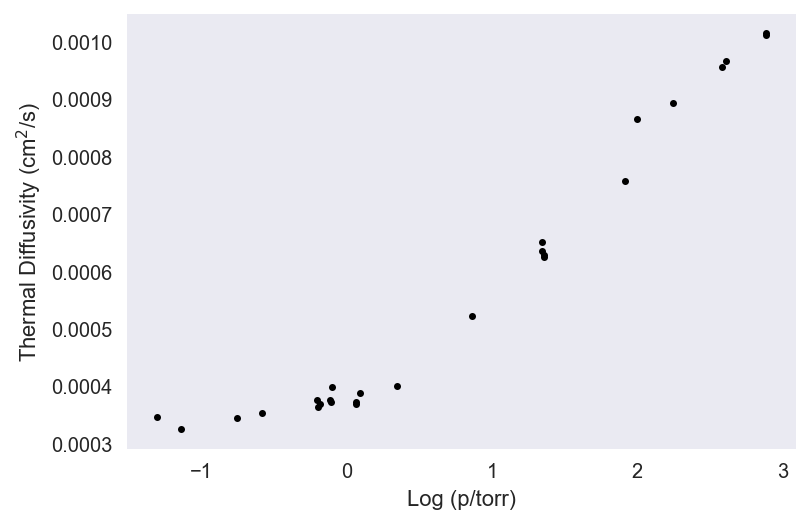

In [128]:
x = np.log10(df_56A175C['torr'])
y_obs = df_56A175C['diff']
data = pd.DataFrame(np.array([x, y_obs]).T, columns=['x', 'y'])
plt.plot(x,y_obs,'k.')
plt.xlabel('Log (p/torr)')
plt.grid()
plt.ylabel('Thermal Diffusivity (cm$^2$/s)');

In [129]:
scalef = 10000 # scaling factor for the diffusivity values 
# THE DATA.
x = np.array(x)     
y = np.array(y_obs)*scalef 

# THE MODEL
with pm.Model() as model:
    # define the priors
    sigma = pm.Gamma('sigma', 0.001, 0.001)
    beta0 = pm.Normal('beta0', mu=3.5, sd=0.3)
    beta1 = pm.Normal('beta1', mu=10.0, sd=1)
    beta2 = pm.Normal('beta2', mu=0.20, sd=1)
    beta3 = pm.Normal('beta3', mu=0.3, sd=0.2)

    def mu(beta0=beta0, beta1=beta1, beta2= beta2,  beta3= beta3, x=x):
        return  beta0 +  beta1/(1 + T.exp(- beta2*(x- beta3)))
    
    regression = pm.Deterministic('regression', mu(beta0,beta1,beta2,beta3,x))
    # define the likelihood
    yl = pm.Normal('yl', mu=regression, sd=sigma, observed=y)
    # Generate a MCMC chain
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace175 = pm.sample(10000, step,'NUTS', start, progressbar=True)
    

Optimization terminated successfully.
         Current function value: 20.975976
         Iterations: 28
         Function evaluations: 40
         Gradient evaluations: 40


100%|██████████████████████████████████| 10500/10500 [00:09<00:00, 1160.89it/s]


In [130]:
# EXAMINE THE RESULTS
burnin = 5000
thin = 10

## Extract chain values:
z0 = trace175['beta0']/scalef
z1 = trace175['beta1']/scalef
z2 = trace175['beta2']
z3 = trace175['beta3']
z_sigma = trace175['sigma']/scalef
#z_sigma = 1 / np.sqrt(z_tau) # Convert precision to SD

b0 = z0
b1 = z1
b2 = z2
b3 = z3
sigma = z_sigma

# Posterior prediction:
# Specify x values for which predicted y's are needed:
#x_post_pred = np.arange(55, 81)
x_post_pred = np.linspace(-2, 4, 200)
# Define matrix for recording posterior predicted y values at each x value.
# One row per x value, with each row holding random predicted y values.
post_samp_size = len(b1)
y_post_pred = np.zeros((len(x_post_pred), post_samp_size))
# Define matrix for recording HDI limits of posterior predicted y values:
y_HDI_lim = np.zeros((len(x_post_pred), 2))
# Generate posterior predicted y values.
# This gets only one y value, at each x, for each step in the chain.
for chain_idx in range(post_samp_size):
    y_post_pred[:,chain_idx] = norm.rvs(loc=sigmoid(b0[chain_idx], b1[chain_idx], b2[chain_idx], b3[chain_idx], x_post_pred),
                           scale = np.repeat([sigma[chain_idx]], [len(x_post_pred)]), size=len(x_post_pred))
#    y_post_pred[:,chain_idx] = norm.rvs(loc=b0[chain_idx] + b1[chain_idx] * x_post_pred ,
#                           scale = np.repeat([sigma[chain_idx]], [len(x_post_pred)]), size=len(x_post_pred))

for x_idx in range(len(x_post_pred)):
    y_HDI_lim[x_idx] = hpd(y_post_pred[x_idx])

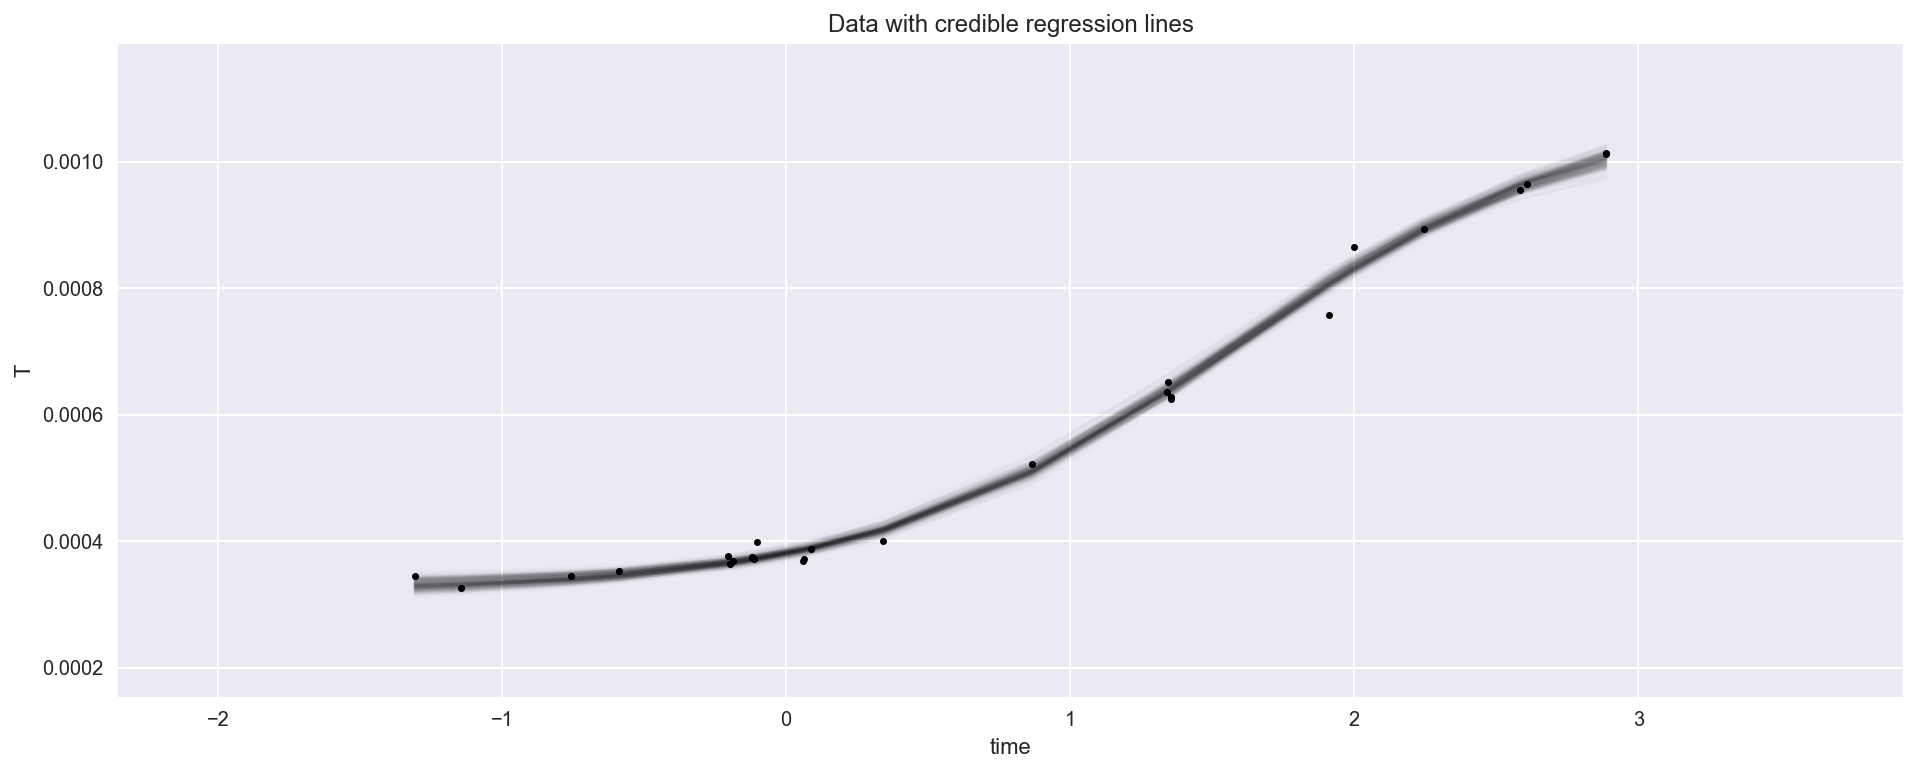

In [131]:
# Display data with believable regression lines and posterior predictions.
plt.figure(figsize=(16,6))
y=y_obs
# Plot data values:
x_rang = np.max(x) - np.min(x)
y_rang = np.max(y) - np.min(y)
lim_mult = 0.25
x_lim = [np.min(x)-lim_mult*x_rang, np.max(x)+lim_mult*x_rang]
y_lim = [np.min(y)-lim_mult*y_rang, np.max(y)+lim_mult*y_rang]
plt.plot(x, y, 'k.')
plt.title('Data with credible regression lines')
plt.xlabel('time')
plt.ylabel('T')
plt.xlim(x_lim)
plt.ylim(y_lim)
# Superimpose a smattering of believable regression lines:
for i in range(0, len(b0), 50):
    plt.plot(x, sigmoid(b0[i], b1[i], b2[i],b3[i], x), c='k', alpha=0.01 )

C:\Users\Jozef\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


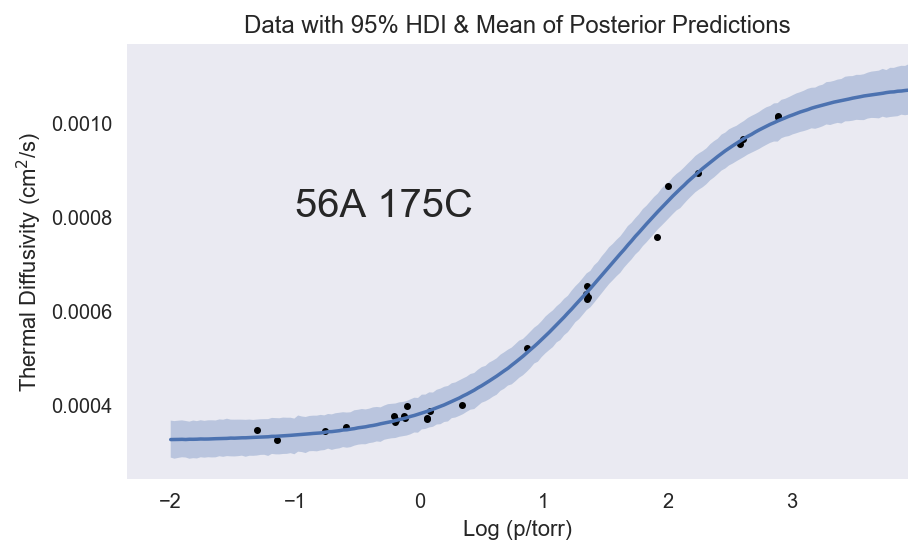

In [132]:
# Display data with HDIs of posterior predictions.

fig = plt.figure(figsize=(7,4))
# Plot data values:
y_lim = [np.min(y_HDI_lim), np.max(y_HDI_lim)]
plt.plot(x, y, 'k.')
plt.xlim(x_lim)
#plt.ylim(y_lim/scalef )
plt.xlabel('Log (p/torr)')
plt.ylabel('Thermal Diffusivity (cm$^2$/s)')
plt.title('Data with 95% HDI & Mean of Posterior Predictions')
# Superimpose posterior predicted 95% HDIs:
y_post_pred_ave = np.average(y_post_pred, axis=1)
#Book version of the Highest Density Interval representation
#plt.errorbar(x_post_pred,y_post_pred_ave, 
#             yerr=[abs(y_HDI_lim[:,0]-y_post_pred_ave),
#                   abs(y_HDI_lim[:,1]-y_post_pred_ave)], fmt='.')

#Smoothed version of the HDI representation
x_new = np.linspace(x_post_pred.min(), x_post_pred.max(), 200)
y_HDI_lim_smooth = spline(x_post_pred, y_HDI_lim, x_new)
plt.plot(x_post_pred, y_post_pred_ave)
plt.fill_between(x_new, y_HDI_lim_smooth[:,0], y_HDI_lim_smooth[:,1], alpha=0.3)
plt.grid()
plt.annotate('56A 175C', xy=(-1, 0.0008), size=20)
plt.show();
fig.savefig('56A175CC.png')

In [133]:
a175 = trace175.get_values('beta0').mean()/scalef # minimum thermal difusivity
b175 = trace175.get_values('beta1').mean()/scalef # delta rise of the thermal diffusivity
c175 = trace175.get_values('beta2').mean()        # slope value of the sigmoid
d175 = trace175.get_values('beta3').mean() # Log(pressure) of 1/2 max rise 
e175 = trace175.get_values('sigma').mean()/scalef
a175, b175, c175, d175, e175

(0.00032339666337302241,
 0.00076278665499190685,
 1.6152725302638622,
 1.5645881145803224,
 1.7781441856742575e-05)

## Analyze 56A310C data

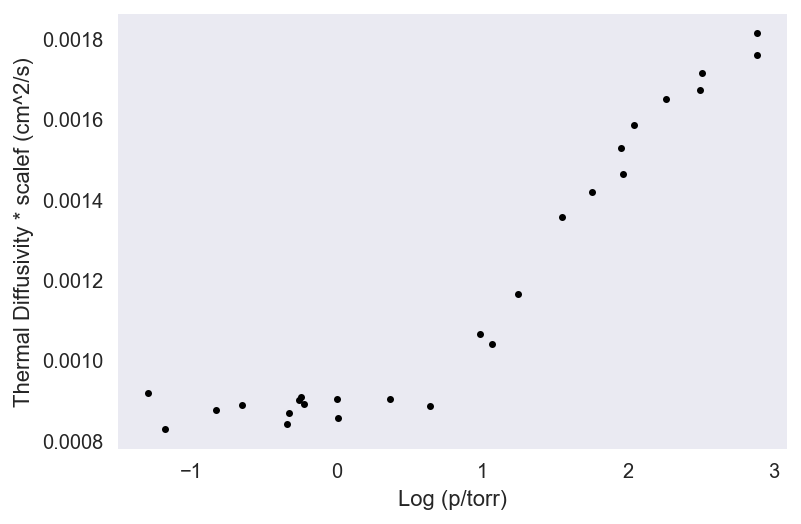

In [134]:
x = np.log10(df_56A310C['torr'])
y_obs = df_56A310C['diff']
data = pd.DataFrame(np.array([x, y_obs]).T, columns=['x', 'y'])
plt.plot(x,y_obs,'k.')
plt.xlabel('Log (p/torr)')
plt.grid()
plt.ylabel('Thermal Diffusivity * scalef (cm^2/s)');

In [135]:
scalef = 10000 # scaling factor for the diffusivity values 
# THE DATA.
x = np.array(x)     
y = np.array(y_obs)*scalef 

# THE MODEL
with pm.Model() as model:
    # define the priors
    sigma = pm.Gamma('sigma', 0.001, 0.001)
    beta0 = pm.Normal('beta0', mu=9, sd=0.3)
    beta1 = pm.Normal('beta1', mu=10.0, sd=1)
    beta2 = pm.Normal('beta2', mu=0.20, sd=1)
    beta3 = pm.Normal('beta3', mu=0.3, sd=0.2)

    def mu(beta0=beta0, beta1=beta1, beta2= beta2,  beta3= beta3, x=x):
        return  beta0 +  beta1/(1 + T.exp(- beta2*(x- beta3)))
    
    regression = pm.Deterministic('regression', mu(beta0,beta1,beta2,beta3,x))
    # define the likelihood
    yl = pm.Normal('yl', mu=regression, sd=sigma, observed=y)
    # Generate a MCMC chain
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace310 = pm.sample(10000, step,'NUTS', start, progressbar=True)
    

Optimization terminated successfully.
         Current function value: 38.473100
         Iterations: 25
         Function evaluations: 34
         Gradient evaluations: 34


100%|██████████████████████████████████| 10500/10500 [00:08<00:00, 1169.47it/s]


In [136]:
# EXAMINE THE RESULTS
burnin = 5000
thin = 10

## Extract chain values:
z0 = trace310['beta0']/scalef
z1 = trace310['beta1']/scalef
z2 = trace310['beta2']
z3 = trace310['beta3']
z_sigma = trace310['sigma']/scalef
#z_sigma = 1 / np.sqrt(z_tau) # Convert precision to SD

b0 = z0
b1 = z1
b2 = z2
b3 = z3
sigma = z_sigma

# Posterior prediction:
# Specify x values for which predicted y's are needed:
#x_post_pred = np.arange(55, 81)
x_post_pred = np.linspace(-2, 4, 200)
# Define matrix for recording posterior predicted y values at each x value.
# One row per x value, with each row holding random predicted y values.
post_samp_size = len(b1)
y_post_pred = np.zeros((len(x_post_pred), post_samp_size))
# Define matrix for recording HDI limits of posterior predicted y values:
y_HDI_lim = np.zeros((len(x_post_pred), 2))
# Generate posterior predicted y values.
# This gets only one y value, at each x, for each step in the chain.
for chain_idx in range(post_samp_size):
    y_post_pred[:,chain_idx] = norm.rvs(loc=sigmoid(b0[chain_idx], b1[chain_idx], b2[chain_idx], b3[chain_idx], x_post_pred),
                           scale = np.repeat([sigma[chain_idx]], [len(x_post_pred)]), size=len(x_post_pred))
#    y_post_pred[:,chain_idx] = norm.rvs(loc=b0[chain_idx] + b1[chain_idx] * x_post_pred ,
#                           scale = np.repeat([sigma[chain_idx]], [len(x_post_pred)]), size=len(x_post_pred))

for x_idx in range(len(x_post_pred)):
    y_HDI_lim[x_idx] = hpd(y_post_pred[x_idx])

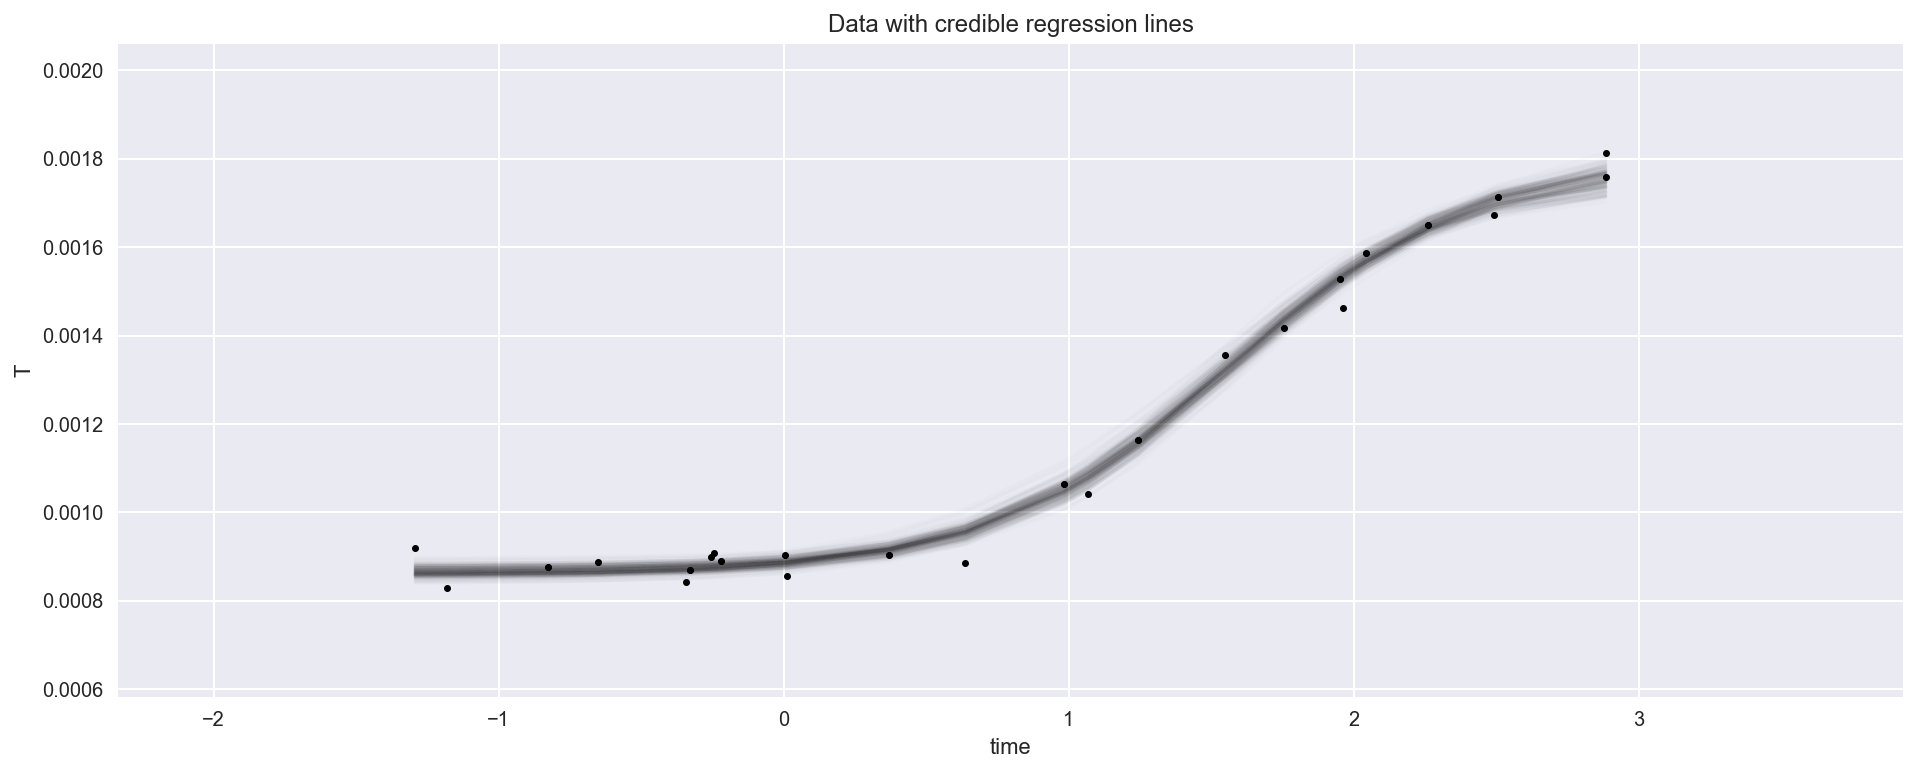

In [137]:
# Display data with believable regression lines and posterior predictions.
plt.figure(figsize=(16,6))
y=y_obs
# Plot data values:
x_rang = np.max(x) - np.min(x)
y_rang = np.max(y) - np.min(y)
lim_mult = 0.25
x_lim = [np.min(x)-lim_mult*x_rang, np.max(x)+lim_mult*x_rang]
y_lim = [np.min(y)-lim_mult*y_rang, np.max(y)+lim_mult*y_rang]
plt.plot(x, y, 'k.')
plt.title('Data with credible regression lines')
plt.xlabel('time')
plt.ylabel('T')
plt.xlim(x_lim)
plt.ylim(y_lim)
# Superimpose a smattering of believable regression lines:
for i in range(0, len(b0), 50):
    plt.plot(x, sigmoid(b0[i], b1[i], b2[i],b3[i], x), c='k', alpha=0.01 )

C:\Users\Jozef\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


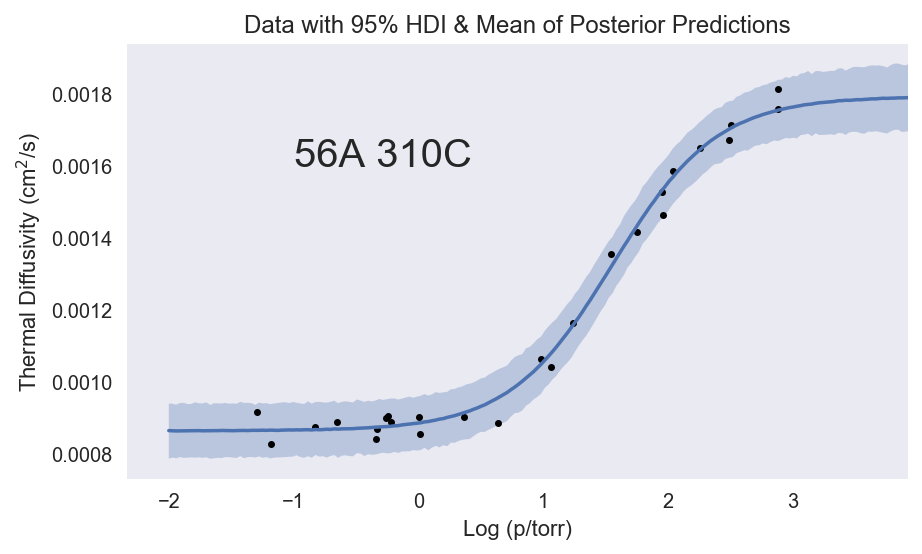

In [138]:
# Display data with HDIs of posterior predictions.

fig = plt.figure(figsize=(7,4))
# Plot data values:
y_lim = [np.min(y_HDI_lim), np.max(y_HDI_lim)]
plt.plot(x, y, 'k.')
plt.xlim(x_lim)
#plt.ylim(y_lim/scalef )
plt.xlabel('Log (p/torr)')
plt.ylabel('Thermal Diffusivity (cm$^2$/s)')
plt.title('Data with 95% HDI & Mean of Posterior Predictions')
# Superimpose posterior predicted 95% HDIs:
y_post_pred_ave = np.average(y_post_pred, axis=1)
#Book version of the Highest Density Interval representation
#plt.errorbar(x_post_pred,y_post_pred_ave, 
#             yerr=[abs(y_HDI_lim[:,0]-y_post_pred_ave),
#                   abs(y_HDI_lim[:,1]-y_post_pred_ave)], fmt='.')

#Smoothed version of the HDI representation
x_new = np.linspace(x_post_pred.min(), x_post_pred.max(), 200)
y_HDI_lim_smooth = spline(x_post_pred, y_HDI_lim, x_new)
plt.plot(x_post_pred, y_post_pred_ave)
plt.fill_between(x_new, y_HDI_lim_smooth[:,0], y_HDI_lim_smooth[:,1], alpha=0.3)
plt.grid()
plt.annotate('56A 310C', xy=(-1, 0.0016), size=20)
plt.show();
fig.savefig('56A310CC.png')

In [139]:
a310 = trace310.get_values('beta0').mean()/scalef # minimum thermal difusivity
b310 = trace310.get_values('beta1').mean()/scalef # delta rise of the thermal diffusivity
c310 = trace310.get_values('beta2').mean()        # slope value of the sigmoid
d310 = trace310.get_values('beta3').mean() # Log(pressure) of 1/2 max rise 
e310 = trace310.get_values('sigma').mean()/scalef
a310, b310, c310, d310, e310

(0.00086468298228711978,
 0.00092877002348873069,
 2.4199210831759972,
 1.5625559054019673,
 3.6135914027966804e-05)

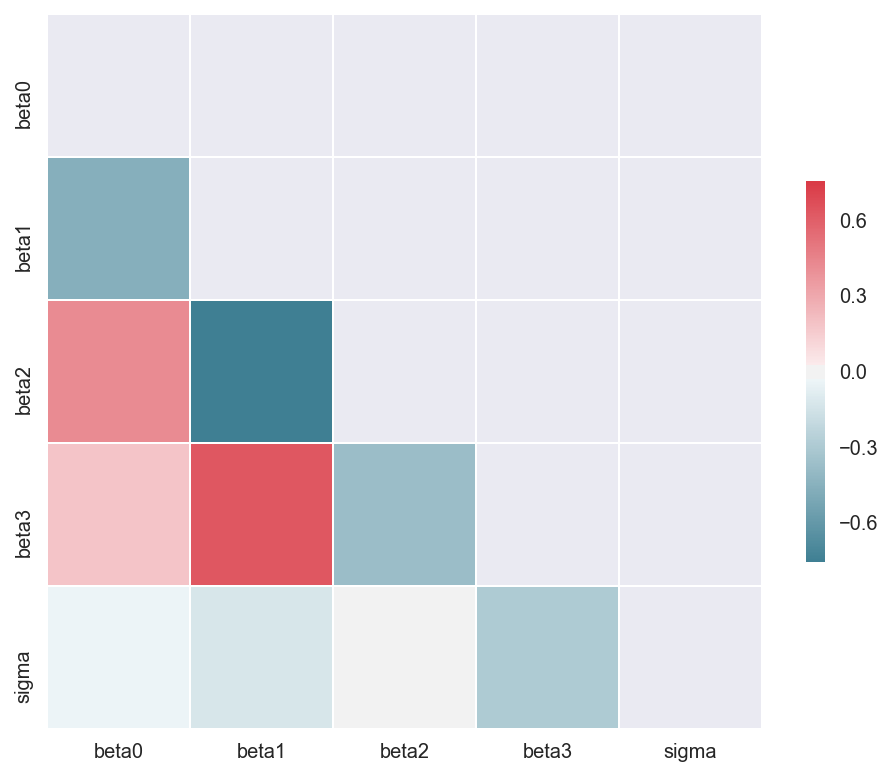

In [140]:
import seaborn as sn
df_trace = pm.trace_to_dataframe(trace175)
df_trace175=df_trace[["beta0","beta1",'beta2','beta3', 'sigma']]

df_trace = pm.trace_to_dataframe(trace310)
df_trace310=df_trace[["beta0","beta1",'beta2','beta3', 'sigma']]

# Compute the correlation matrix
corr175 = df_trace310.corr()
corr310 = df_trace310.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr175, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 7))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr175, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

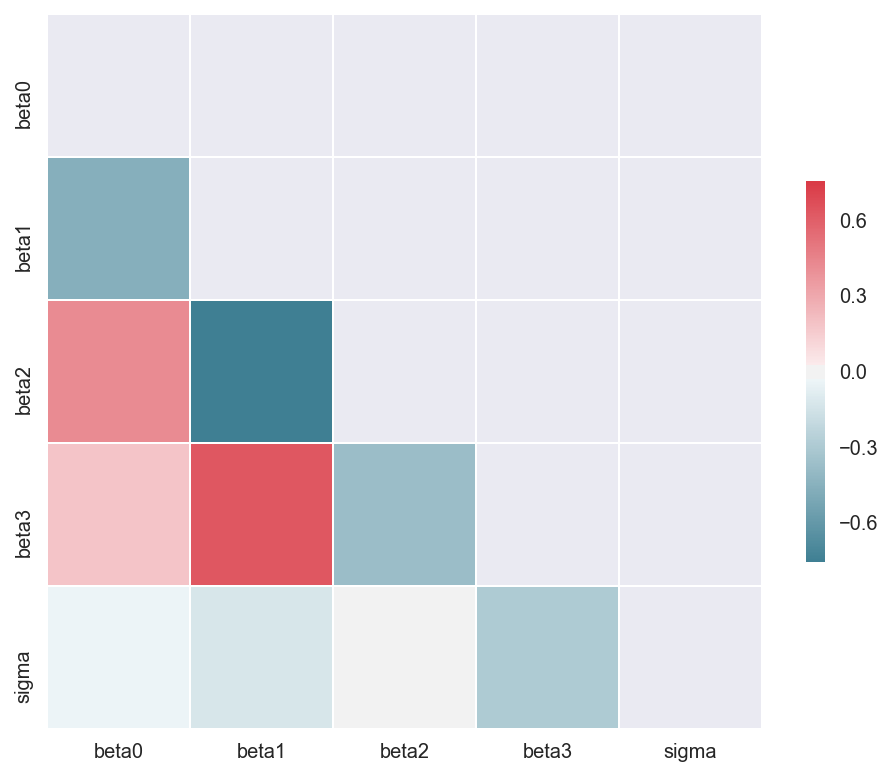

In [141]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr310, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 7))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr310, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

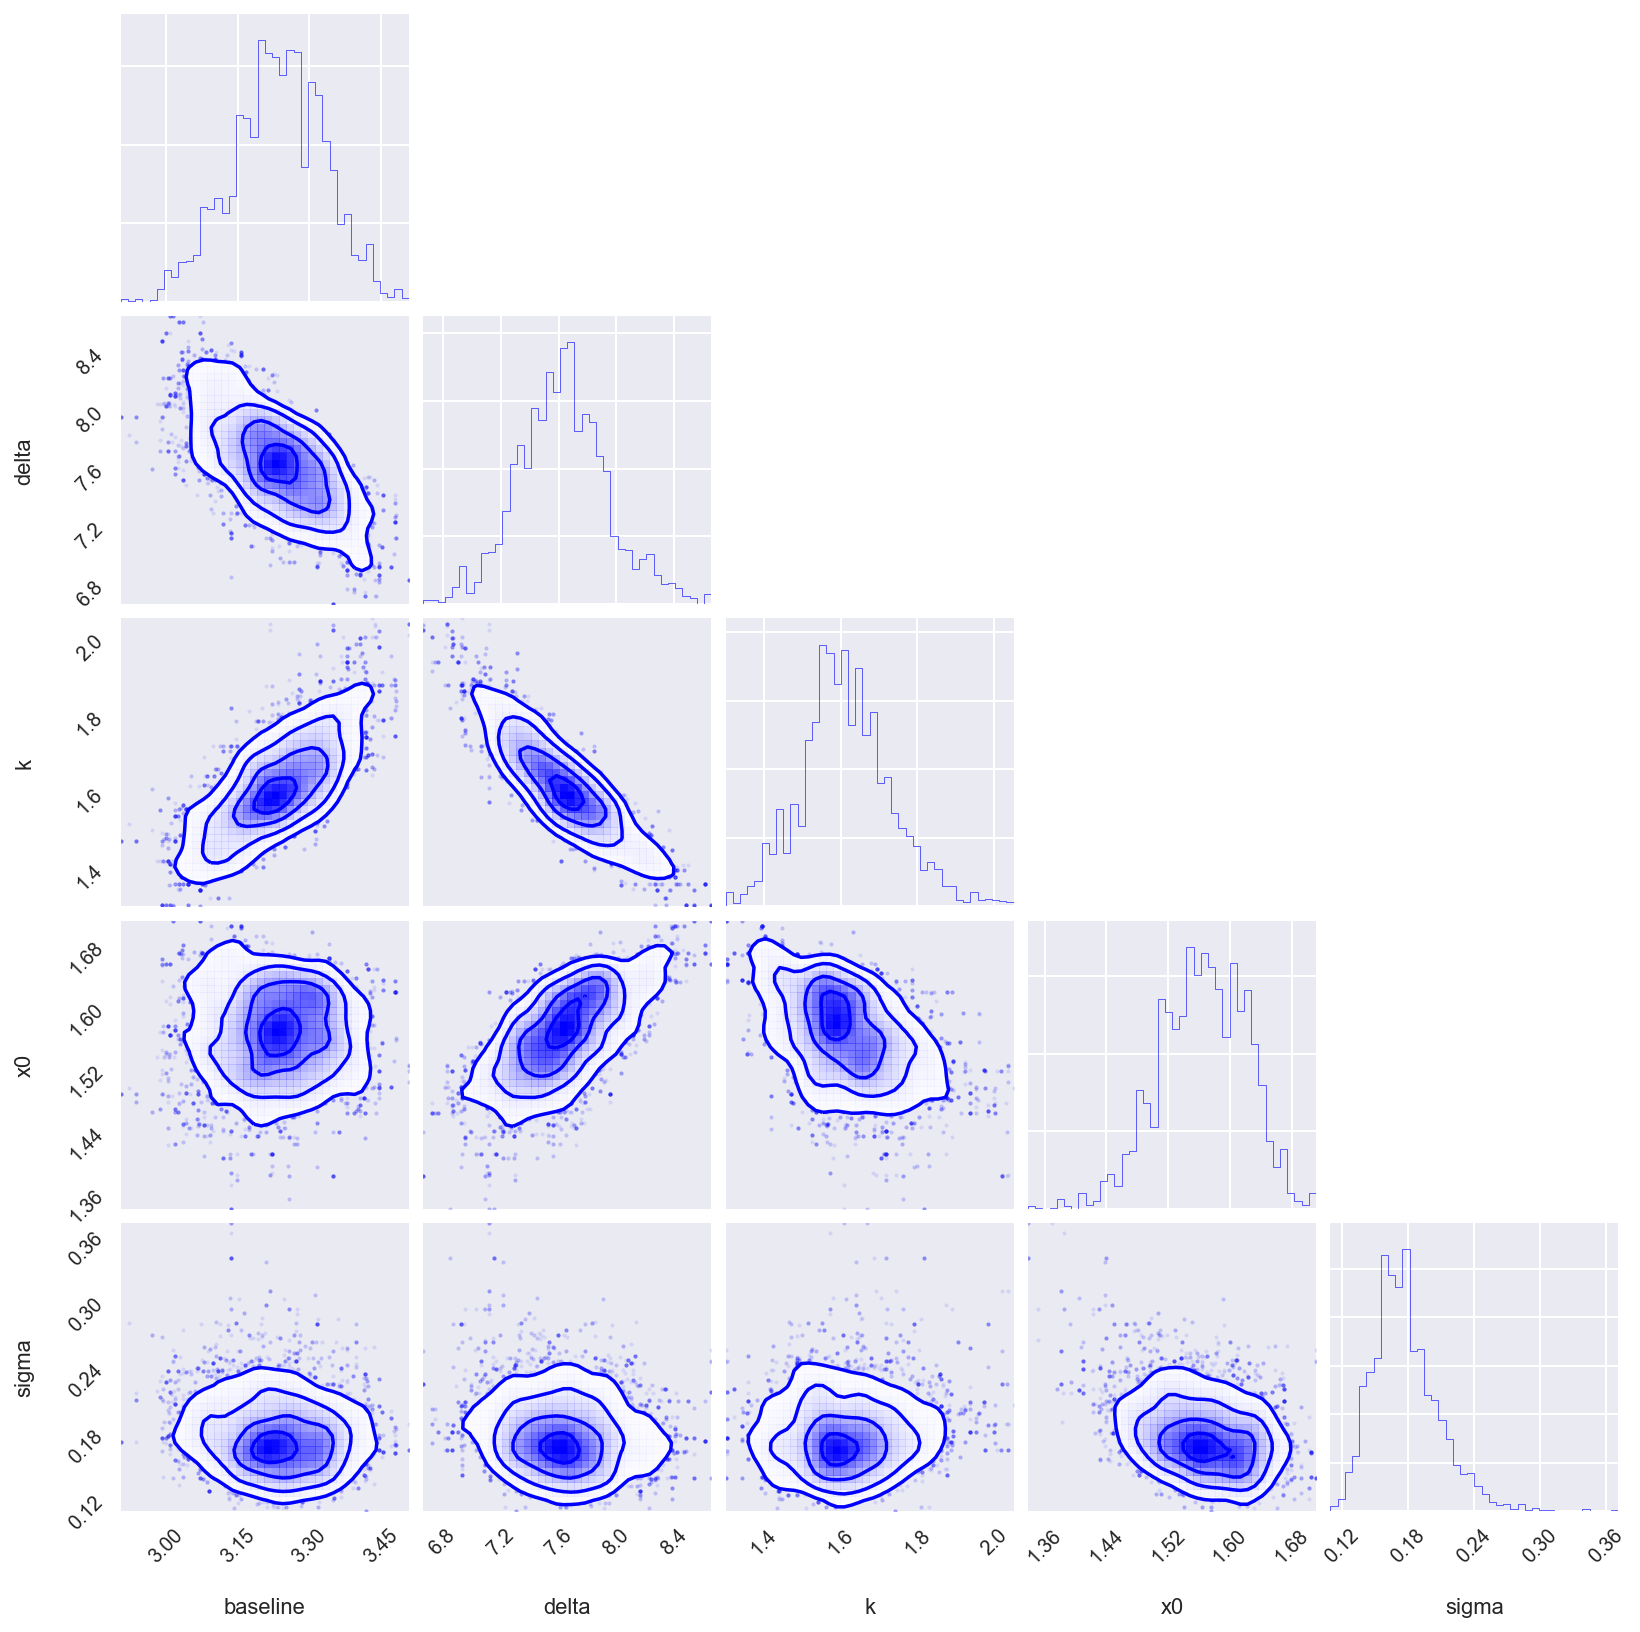

In [142]:
import numpy as np
samples = df_trace175
#!pip install corner #or pip install triangle_plot
import corner
figure = corner.corner(samples, color="b", bins=40, filled= True, smooth=(1.5),fill_contours=False,
                       labels=["baseline","delta",'k','x0', 'sigma'])#, 
               # truths=[a, b, c, d, e])
#figure.savefig('full_figure.png')

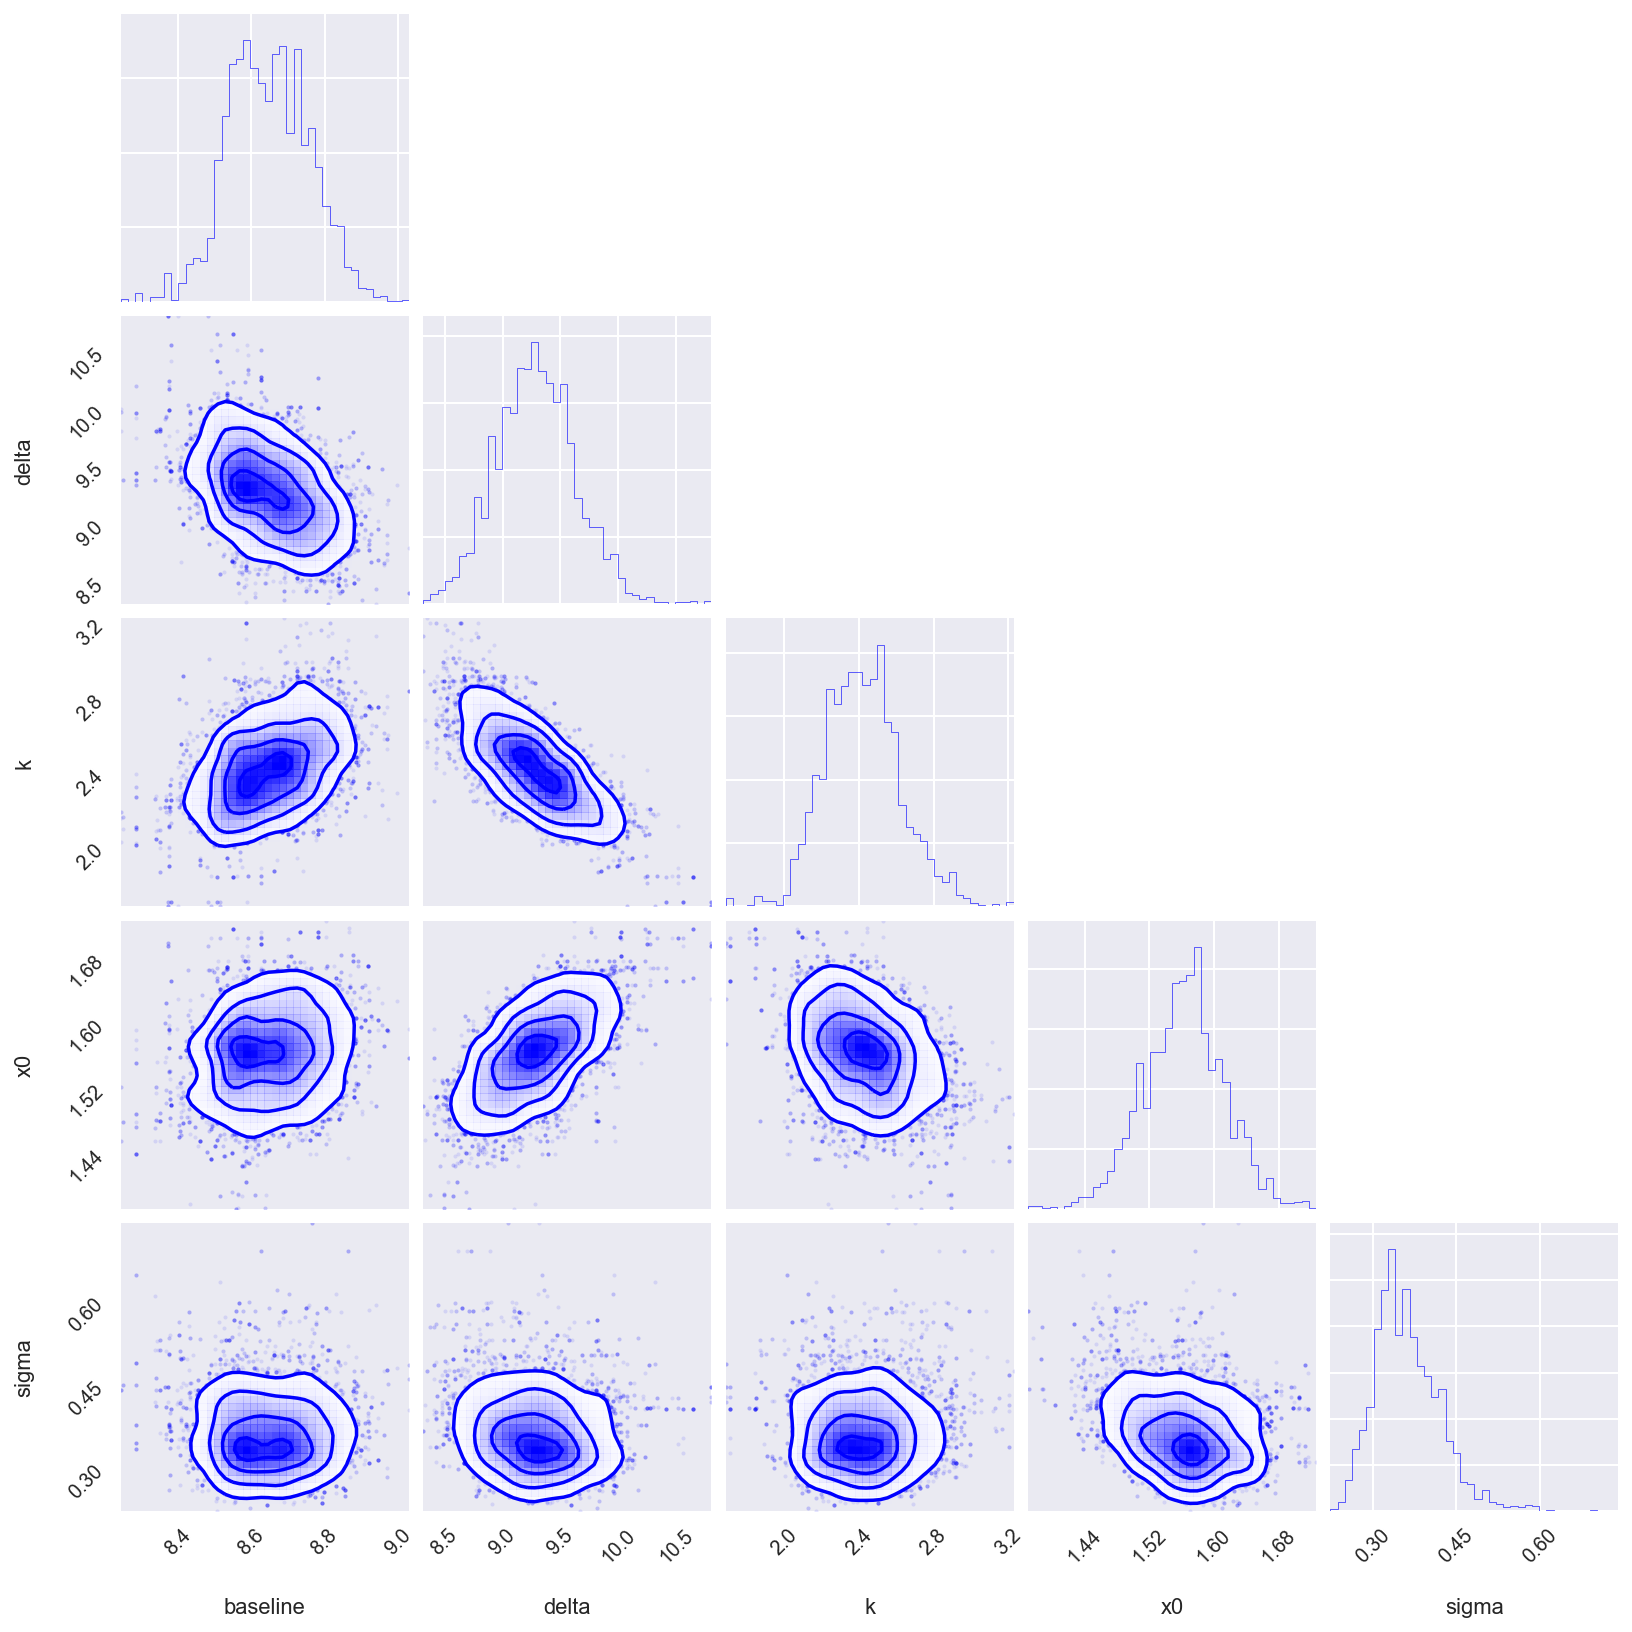

In [143]:
import numpy as np
samples = df_trace310
#!pip install corner #or pip install triangle_plot
import corner
figure = corner.corner(samples, color="b", bins=40, filled= True, smooth=(1.5),fill_contours=False,
                       labels=["baseline","delta",'k','x0', 'sigma']) #, 
               # truths=[a, b, c, d, e])
#figure.savefig('full_figure.png')

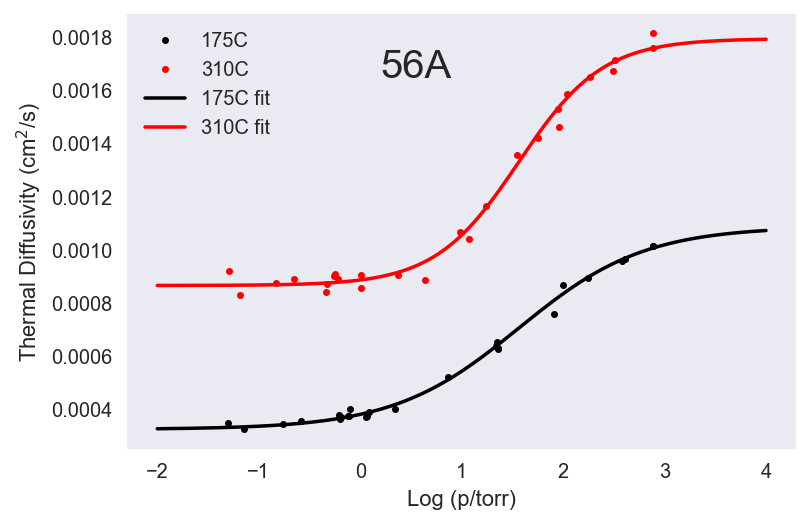

In [144]:
x175 = np.log10(df_56A175C['torr'])
y_obs175 = df_56A175C['diff']

x310 = np.log10(df_56A310C['torr'])
y_obs310 = df_56A310C['diff']

fig = plt.figure(figsize=(6,4))
plt.plot(x175,y_obs175,'k.',label="175C")
plt.plot(x310,y_obs310,'r.',label="310C")
plt.plot(x_new,sigmoid(a175, b175, c175, d175, x_new),'k',label="175C fit")
plt.plot(x_new,sigmoid(a310, b310, c310, d310, x_new),'r',label="310C fit")
plt.xlabel('Log (p/torr)')
plt.annotate('56A', xy=(0.2, 0.00165), size=20)
plt.legend()
plt.grid()
plt.ylabel('Thermal Diffusivity (cm$^2$/s)');
plt.show();

fig.savefig('diffs.eps')

## Normalized Diffusivities
respected $a$ values, calculated by fitting data with sigmoids, were substracted from the experimental diffusivity points and the results were then divided by the respective $b$ values  

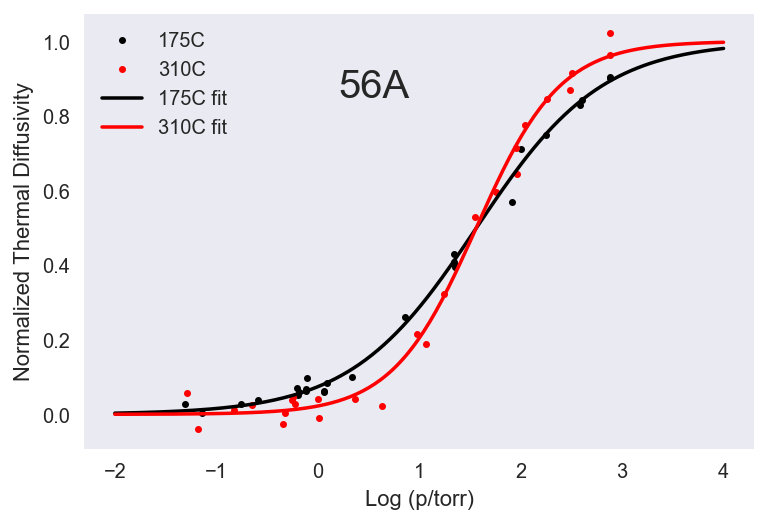

In [145]:
# normalized data
x175 = np.log10(df_56A175C['torr'])
y_obs175n = (df_56A175C['diff']-a175)/b175

x_new = np.linspace(-2, 4, 200)

x310 = np.log10(df_56A310C['torr'])
y_obs310n = (df_56A310C['diff']-a310)/b310

fig = plt.figure(figsize=(6,4))
plt.plot(x175,y_obs175n,'k.',label="175C")
plt.plot(x310,y_obs310n,'r.',label="310C")
plt.plot(x_new,sigmoid(0, 1, c175, d175, x_new),'k',label="175C fit")
plt.plot(x_new,sigmoid(0, 1, c310, d310, x_new),'r',label="310C fit")
plt.xlabel('Log (p/torr)')
plt.annotate('56A', xy=(0.2, 0.85), size=20)
plt.legend()
plt.grid()
plt.ylabel('Normalized Thermal Diffusivity');
fig.savefig('normdiffs.eps')

#### It is interesting that the $c$ values (midpoints) are the same for both temperatures (1.57)

In [146]:
dm175 = trace175.get_values('beta3').mean()
dstd175 = trace175.get_values('beta3').std()
dm310 = trace310.get_values('beta3').mean()
dstd310 = trace310.get_values('beta3').std()
print('     Midpoints:\n 175\n d =',dm175,'+/-',dstd175,'\n 310\n d = ',dm310,'+/-', dstd310)

     Midpoints:
 175
 d = 1.56458811458 +/- 0.0560171477489 
 310
 d =  1.5625559054 +/- 0.04985697829


In [147]:
pm.summary(trace310)


beta0:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  8.647            0.111            0.006            [8.450, 8.871]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  8.432          8.569          8.642          8.726          8.860


beta1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  9.288            0.347            0.023            [8.670, 9.999]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  8.644          9.052          9.282          9.513          9.981


beta2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------